# Step #1 Load the Data

In [5]:
#https://github.com/flo7up/relataly-public-python-tutorials/blob/master/007%20Time%20Series%20Forecasting%20-%20Multivariate%20Time%20Series%20Models.ipynb
#https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates

from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns # Visualization

import tensorflow as tf
# from tensorflow.keras import Sequential # Deep learning library, used for neural networks
# from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
# from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
# from tensorflow.keras.models import load_model

# from keras.models import Sequential
# from keras.layers import Dense,LSTM ,Flatten,Dropout  
# from keras.callbacks import EarlyStopping
# from keras.models import load_model

from sklearn.model_selection import train_test_split

model_name='Model-ExplainMultiVarToOne.h5'
    


In [6]:
ab_path = "../data/SET50-Daily-Y09-Now.csv"
stockname='SET50'
start_date='2016-01-01'
end_date='2022-12-31'

#How much ratio to splittrain_ratio=0.8


way=2 
#1=Single 2=2 Layer and 3=Dropput
validate_train_test=True

split_way=1

train_ratio=0.8

date_col='Date'
#=======Great====================
prediction_col='Price'
# feature_cols=['Price','EMA1']  
# Root MEAN Square Error(RMSE): 8.35
# Median Absolute Error (MAE): 6.77


# feature_cols=['Price','EMA1', 'MACD', 'RSI']
feature_cols=['Price', 'EMA1','EMA2', 'MACD', 'RSI']


#prediction_col='MACD'
#feature_cols=['MACD', 'SIGNAL','RSI-MA']

# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 66



#epochs =100
epochs =10 # for test shap

batch_size = 32
n_early=0


In [7]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':date_col},inplace=True)
df.drop(columns=['Ticker'],inplace=True)
allCols=list(df.columns)
print(allCols)

df[date_col]=df[date_col].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
df.set_index(date_col,inplace=True)
df=df.loc[start_date:end_date,:]
df=df[feature_cols]
print(df.info())
df.tail()

['Date', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1692 entries, 2016-01-04 to 2022-12-16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1692 non-null   float64
 1   EMA1    1692 non-null   float64
 2   EMA2    1692 non-null   float64
 3   MACD    1692 non-null   float64
 4   RSI     1692 non-null   float64
dtypes: float64(5)
memory usage: 79.3 KB
None


,Price,EMA1,EMA2,MACD,RSI
Date,,,,,
2022-12-09,979.01,983.19,983.62,-0.43,46.93
2022-12-13,981.17,982.82,983.38,-0.56,48.86
2022-12-14,984.70,983.16,983.51,-0.34,51.92
2022-12-15,978.58,982.33,983.04,-0.71,46.72
2022-12-16,980.24,981.95,982.77,-0.82,48.23


# Step #2 Exploring the Data

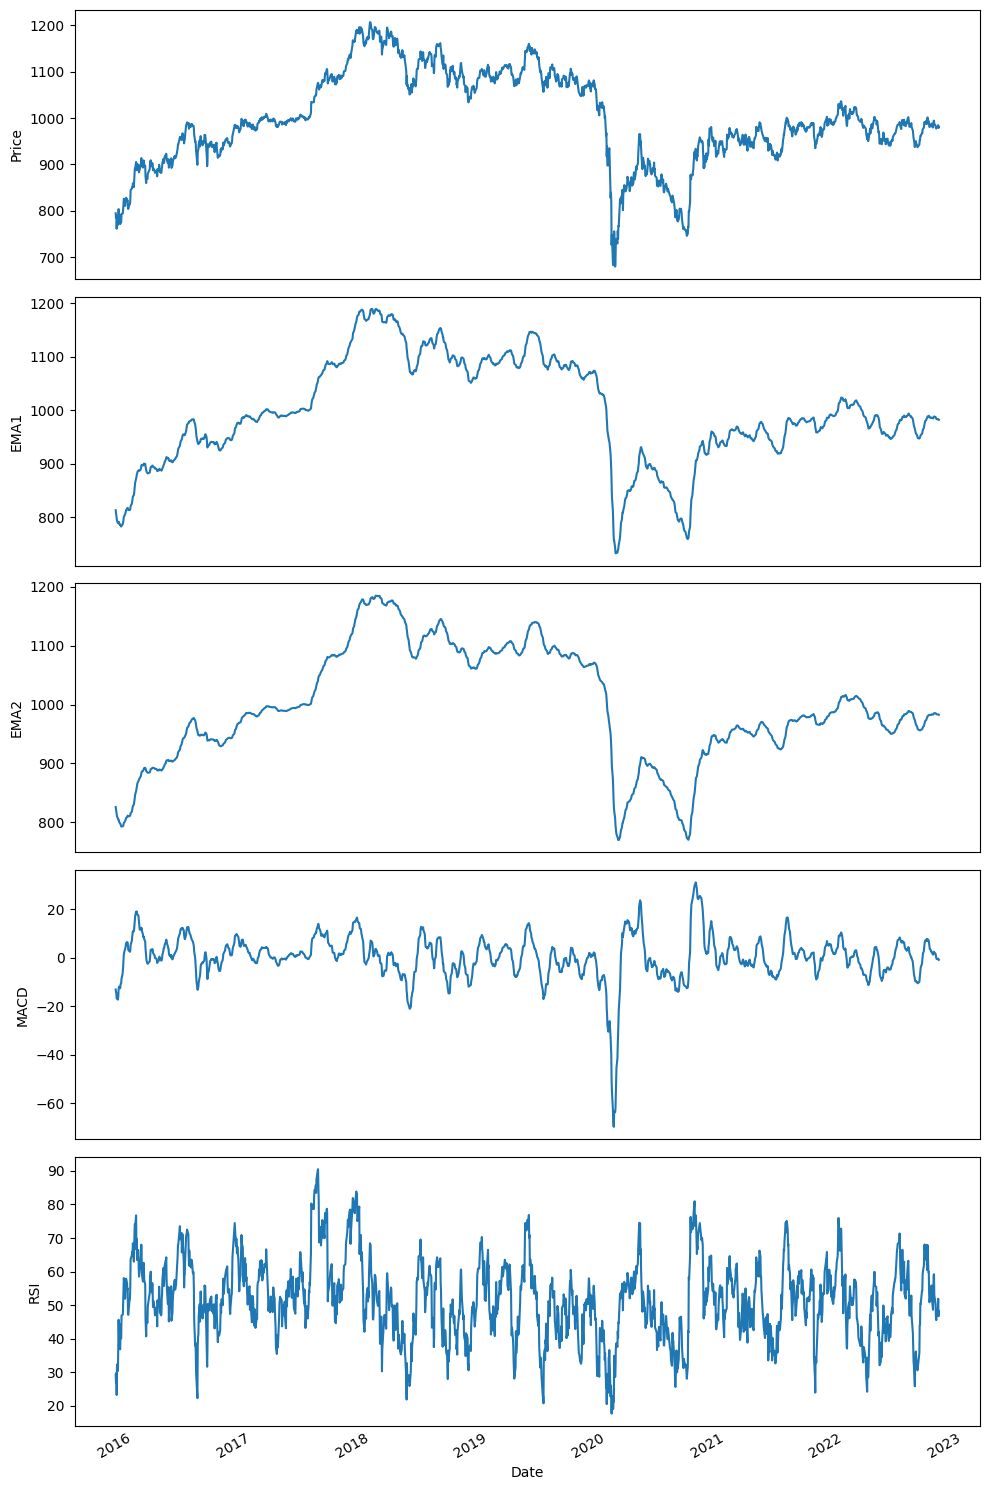

In [8]:
# Plot line charts
df_plot = df.copy()

ncols = 1
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(10, 15))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# Step #3 Preprocessing and Feature Selection

In [9]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES =feature_cols

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext[prediction_col]

# Print the tail of the dataframe
print(data_filtered.shape)
print(data_filtered.tail())
print(data_filtered_ext.shape)
print(data_filtered_ext.tail())
data_filtered.info()

FEATURE LIST
['Price', 'EMA1', 'EMA2', 'MACD', 'RSI']
(1692, 5)
             Price    EMA1    EMA2  MACD    RSI
Date                                           
2022-12-09  979.01  983.19  983.62 -0.43  46.93
2022-12-13  981.17  982.82  983.38 -0.56  48.86
2022-12-14  984.70  983.16  983.51 -0.34  51.92
2022-12-15  978.58  982.33  983.04 -0.71  46.72
2022-12-16  980.24  981.95  982.77 -0.82  48.23
(1692, 6)
             Price    EMA1    EMA2  MACD    RSI  Prediction
Date                                                       
2022-12-09  979.01  983.19  983.62 -0.43  46.93      979.01
2022-12-13  981.17  982.82  983.38 -0.56  48.86      981.17
2022-12-14  984.70  983.16  983.51 -0.34  51.92      984.70
2022-12-15  978.58  982.33  983.04 -0.71  46.72      978.58
2022-12-16  980.24  981.95  982.77 -0.82  48.23      980.24
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1692 entries, 2016-01-04 to 2022-12-16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ----

In [10]:
nrows = data_filtered.shape[0]
print(f"Get the number of rows in the data {nrows}")

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)



Get the number of rows in the data 1692
(1692, 5)


# Split the training data into train and train data sets

In [11]:
index_Close = data.columns.get_loc(prediction_col)
print(f"Prediction Index = {index_Close}")

train_data_len = math.ceil(np_data_unscaled.shape[0] * train_ratio)
print(f"The number of rows to train the model on  {train_ratio } of the data = {train_data_len}")

Prediction Index = 0
The number of rows to train the model on  0.8 of the data = 1354


# Transform the data by scaling each feature to a range between 0 and 1

In [12]:

scaler = MinMaxScaler()
# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
#scaler= RobustScaler()



if split_way==1:
    print("Way#1 scale entire data and split data")
    np_data_scaled = scaler.fit_transform(np_data_unscaled)    
    
    df_PredictVal = pd.DataFrame(data_filtered_ext[prediction_col])
    np_PredictVal_scaled = scaler_pred.fit_transform(df_PredictVal)
    
    print(np_data_scaled.shape,np_PredictVal_scaled.shape)
    print(np_data_scaled[:3],np_PredictVal_scaled[:3])
    
    # Create the training and test data
    train_data = np_data_scaled[0:train_data_len, :]
    test_data = np_data_scaled[train_data_len - sequence_length:, :]


else:
    print("#Way#2 split data and apply  only train to scale")
    
    train_data = np_data_unscaled[0:train_data_len, :]
    test_data = np_data_unscaled[train_data_len - sequence_length:, :]
    train_data=scaler.fit_transform(train_data)
    test_data=scaler.transform(test_data)
        
    df_PredictVal=data_filtered_ext.iloc[0:train_data_len][[prediction_col]]
    np_PredictVal_scaled = scaler_pred.fit_transform(df_PredictVal)
    
print("Scaled data completely")    
print("train and test data")
print(train_data.shape,test_data.shape)
print(train_data[:1])
print(test_data[:1])

print("predict val data")
print(np_PredictVal_scaled.shape)
print(np_PredictVal_scaled[:3])

Way#1 scale entire data and split data
(1692, 5) (1692, 1)
[[0.21830344 0.17640486 0.13540839 0.56198593 0.15973081]
 [0.20076391 0.1655603  0.12616451 0.55098603 0.12621893]
 [0.20893509 0.15839632 0.1187983  0.54890496 0.16632331]] [[0.21830344]
 [0.20076391]
 [0.20893509]]
Scaled data completely
train and test data
(1354, 5) (404, 5)
[[0.21830344 0.17640486 0.13540839 0.56198593 0.15973081]]
[[0.50628991 0.48881586 0.45357599 0.66534536 0.35283615]]
predict val data
(1692, 1)
[[0.21830344]
 [0.20076391]
 [0.20893509]]


In [13]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

print(x_train[-2:])
print(y_train[-2:])

(1288, 66, 5) (1288,)
(338, 66, 5) (338,)
0.34193523867436904
0.34193523867436904
[[[0.52415248 0.50123781 0.46118293 0.69021901 0.41175663]
  [0.49599042 0.49321941 0.45653692 0.67307502 0.30146958]
  [0.50628991 0.48881586 0.45357599 0.66534536 0.35283615]
  [0.53257069 0.49072188 0.45408151 0.67198494 0.4653207 ]
  [0.53943068 0.49370139 0.45535736 0.68030919 0.49114133]
  [0.53553512 0.49534451 0.45603139 0.6848677  0.4741107 ]
  [0.51784357 0.49297842 0.45451482 0.68040828 0.40159319]
  [0.49893585 0.48706321 0.45085578 0.6687147  0.33470677]
  [0.5013872  0.48274729 0.44784671 0.66157963 0.3461063 ]
  [0.50028504 0.47900099 0.44498207 0.65632742 0.34212333]
  [0.52099802 0.48024975 0.44490985 0.66247151 0.43702788]
  [0.54058984 0.48539818 0.44719675 0.67624616 0.51229227]
  [0.5242855  0.48618688 0.44729304 0.6794173  0.44554319]
  [0.47423229 0.47635009 0.4413471  0.65939946 0.29048208]
  [0.50448465 0.47461934 0.43961388 0.65870578 0.39733553]
  [0.52396245 0.47731405 0.440408

# Step #4 Model Training

In [14]:
# Configure the neural network model
model = tf.keras.models.Sequential()

#n_neurons=50
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])

model.add(tf.keras.layers.LSTM(n_neurons, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2]))) 

# model.add(tf.keras.layers.LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
# model.add(tf.keras.layers.LSTM(n_neurons, return_sequences=False))

model.add(tf.keras.layers.Dense(1))

print(f"Way={way} : Model with {n_neurons} = {x_train.shape[1]} inputshape Timestamps x {x_train.shape[2]} variables")

# Compile the model
# model.compile(optimizer='adam', loss='mse')
model.compile(optimizer='adam',loss='mean_squared_error')

330 66 5
Way=2 : Model with 330 = 66 inputshape Timestamps x 5 variables


In [15]:

if n_early==0:
    print("Training the model")
    if validate_train_test:
     history = model.fit(x_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs,shuffle=False
                        ,validation_data=(x_test, y_test)
                       )
    else:
     history = model.fit(x_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs,shuffle=False
                       )   
else:
    print(f"Training the model with EarlyStop = {n_early}")
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=n_early, verbose=1)
    history = model.fit(x_train, y_train, 
                        batch_size=batch_size, 
                        epochs=epochs,shuffle=False,
                         validation_data=(x_test, y_test),
                      EarlyStopping =[early_stop])
    


Training the model
Epoch 1/10
41/41 [==============================] - 22s 455ms/step - loss: 0.0123 - val_loss: 0.0125
Epoch 2/10
41/41 [==============================] - 14s 351ms/step - loss: 0.0036 - val_loss: 0.0044
Epoch 3/10
41/41 [==============================] - 14s 345ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 4/10
41/41 [==============================] - 16s 394ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 5/10
41/41 [==============================] - 14s 346ms/step - loss: 0.0015 - val_loss: 9.7530e-04
Epoch 6/10
41/41 [==============================] - 16s 386ms/step - loss: 0.0013 - val_loss: 6.4147e-04
Epoch 7/10
41/41 [==============================] - 14s 335ms/step - loss: 0.0012 - val_loss: 5.7821e-04
Epoch 8/10
41/41 [==============================] - 14s 339ms/step - loss: 0.0012 - val_loss: 5.4176e-04
Epoch 9/10
41/41 [==============================] - 15s 369ms/step - loss: 0.0012 - val_loss: 5.1630e-04
Epoch 10/10
41/41 [==============================] -

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 330)               443520    
                                                                 
 dense (Dense)               (None, 1)                 331       
                                                                 
Total params: 443,851
Trainable params: 443,851
Non-trainable params: 0
_________________________________________________________________


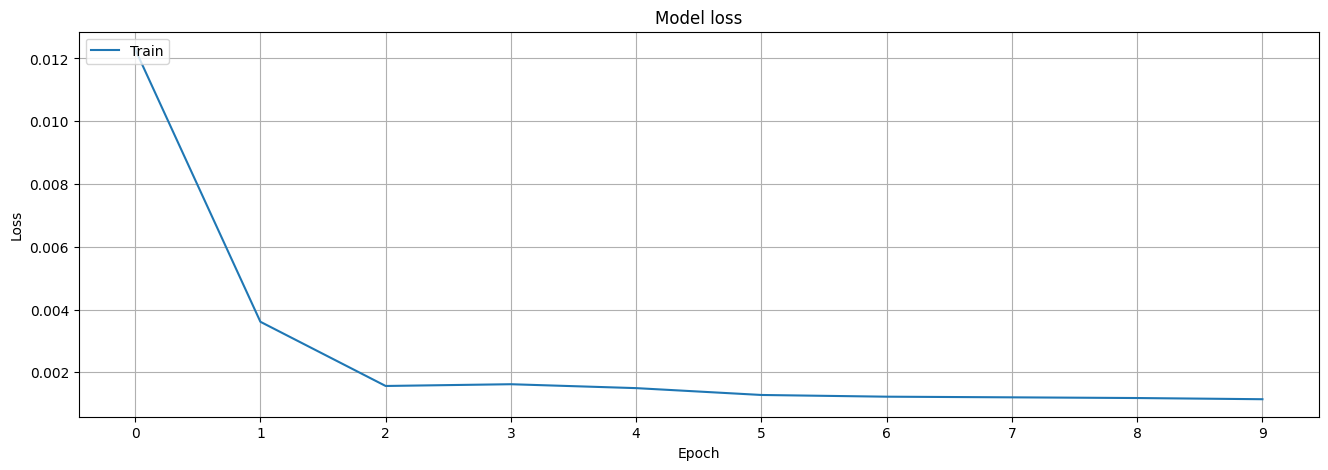

In [19]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train"], loc="upper left")
plt.grid()
plt.show()

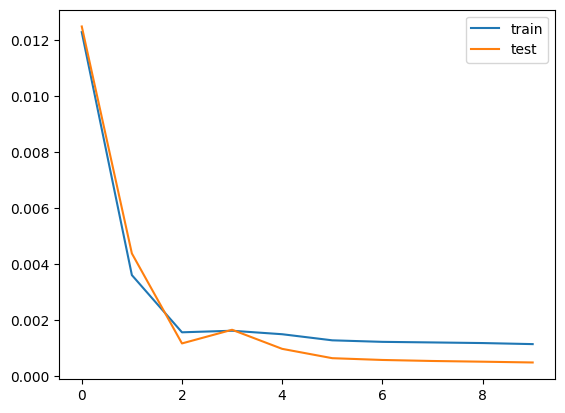

In [20]:
if validate_train_test:
# validation_data=(x_test, y_test)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

In [23]:
# Save model
#model.save(model_name)
x_train.shape

(1288, 66, 5)

In [24]:
import shap

# explainer_ = shap.DeepExplainer(model,x_train)
# shap_values_ = explainer_.shap_values(x_test)

NameError: name 'train_X' is not defined

# Step #5 Evaluate Model Performance

In [40]:
# load model
#model = load_model(model_name)

In [41]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
print(y_pred_scaled.shape)
y_pred_scaled[:1]


11/11 [==============================] - 1s 25ms/step
(338, 1)


array([[0.6134632]], dtype=float32)

In [42]:
# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

print(y_pred.shape)
print(y_pred[:1])

print(y_test_unscaled.shape)
print(y_test_unscaled[:1])

(338, 1)
[[-7.875427]]
(338, 1)
[[-7.65]]


In [43]:
RMSE = np.sqrt(mean_squared_error(y_test_unscaled, y_pred))
print(f'Root MEAN Square Error(RMSE): {np.round(RMSE, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')


# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Root MEAN Square Error(RMSE): 2.06
Mean Absolute Error (MAE): 1.67
Mean Absolute Percentage Error (MAPE): 154.92 %
Median Absolute Percentage Error (MDAPE): 37.29 %


# Visualize Data

In [44]:

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext[prediction_col][:train_data_len + 1]).rename(columns={prediction_col: 'y_train'})
valid = pd.DataFrame(data_filtered_ext[prediction_col][train_data_len:]).rename(columns={prediction_col: 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

df_union.tail()

,y_train,y_test,residuals,y_pred
Date,,,,
2022-12-09,NaN,-0.43,0.838410,0.408410
2022-12-13,NaN,-0.56,-0.035588,-0.595588
2022-12-14,NaN,-0.34,-1.176903,-1.516903
2022-12-15,NaN,-0.71,-1.386275,-2.096275
2022-12-16,NaN,-0.82,-1.633759,-2.453759


In [45]:
# The date from which on the date is displayed
display_start_date = "2021-07-01" 
df_union_zoom = df_union[df_union.index > display_start_date]
print(df_union_zoom.tail())

            y_train  y_test  residuals    y_pred
Date                                            
2022-12-09      NaN   -0.43   0.838410  0.408410
2022-12-13      NaN   -0.56  -0.035588 -0.595588
2022-12-14      NaN   -0.34  -1.176903 -1.516903
2022-12-15      NaN   -0.71  -1.386275 -2.096275
2022-12-16      NaN   -0.82  -1.633759 -2.453759


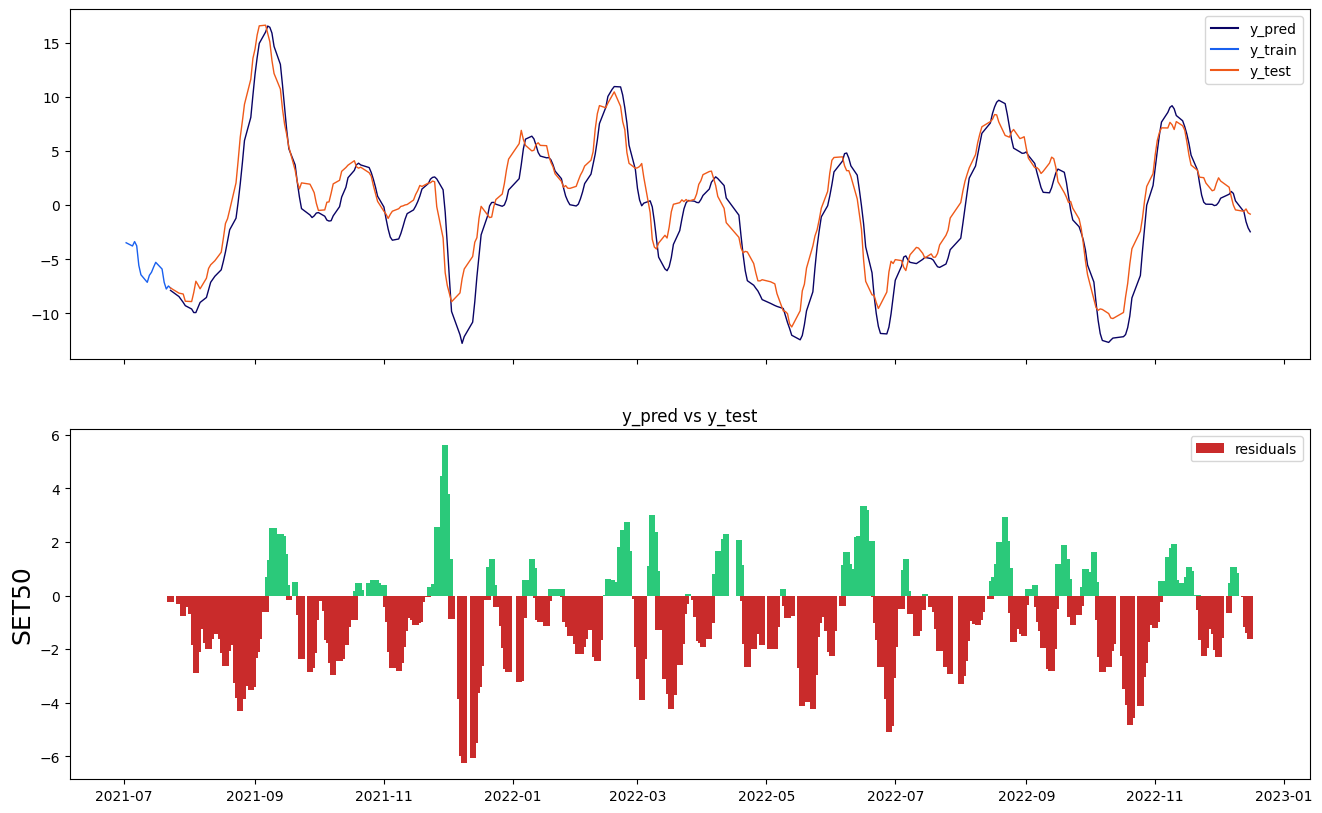

In [46]:
# Zoom in to a closer timeframe


# Create the lineplot
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1,figsize=(16, 10),sharex=True)
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax2.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

# Step #6 Predict Next Day's Price

In [47]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df[prediction_col][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 42ms/step
The close price for SET50 at 2022-12-31 was -0.82
The predicted close price is -2.549999952316284 (+67.84%)
